# 3/8/21 - This notebook analyzes the results of the G3629152_1933's models.

In [33]:
### libraries
%matplotlib inline
# set workspace path
from pyprojroot import here
workspace_path = str(here())#'/data/sknabel/autolens_workspace'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
import numpy as np
from astropy import constants as const
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.cosmology import FlatLambdaCDM, z_at_value
#from astropy.stats import sigma_clip as clip
import astropy.cosmology as cosmo
from os import path
import time

c = const.c.to('km/s').value #c in km/s
h0 = 73.8 #h0 in km/(Mpc*s) Riess2011
cosmo = FlatLambdaCDM(h0, Om0=0.262)

# set datetime variable
datetime = time.strftime("%d%m%Y-%H%M%S")

# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
png_path = f'{autoz_path}visuals/png/'
pdf_path = f'{autoz_path}visuals/pdf/'

/data/sknabel/autoz_lens_model
Working Directory has been set to `/data/sknabel/autoz_lens_model`


In [34]:
# this should be constant across experiments

gama_id = 3629152
links_id = 1933

object_folder = f'{fits_path}G{gama_id}_{links_id}/'
output_folder = f'{autoz_path}output/G{gama_id}_{links_id}/'

# load object data table
links = pd.read_csv(f'{csv_path}/latest/links_sample_latest.csv')
lens_galaxy_data = links[links.GAMA_ID == gama_id]
stellar_mass = lens_galaxy_data.lambdar_log_mstar.values
zlens=lens_galaxy_data.zlens.values
zsource=lens_galaxy_data.zsource.values
einstein_radius=np.mean([lens_galaxy_data.theta_e_pm.values, lens_galaxy_data.theta_e_sis.values]) # take average of einstein radius estimates for prior
print(f'Lens and source redshifts at {zlens} and {zsource}.')
print(f'Einstein radius prior: {einstein_radius}')

# load performance log from csv
performance_log = pd.read_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(performance_log)
print(f'Performance log: {performance_log}')

Lens and source redshifts at [0.40662315] and [0.78711778].
Einstein radius prior: 0.7778450206448699
Performance log:    Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0           0           0.0             0.0               0.0   
1           1           1.0             1.0               1.0   
2           2           2.0             2.0               0.0   
3           3           3.0             0.0               NaN   
4           4           0.0             NaN               NaN   
5           0           NaN             NaN               NaN   

   Unnamed: 0.1.1.1.1  Unnamed: 0.1.1.1.1.1 Experiment  phase1_time  \
0                 0.0                   0.0          1   403.158289   
1                 0.0                   NaN          2   151.080091   
2                 NaN                   NaN         2a   163.102591   
3                 NaN                   NaN          3   176.824480   
4                 NaN                   NaN          3   162.736001   

Plotting r-band


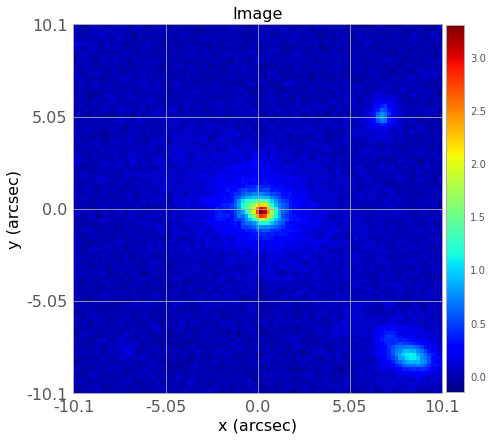

Plotting g-band


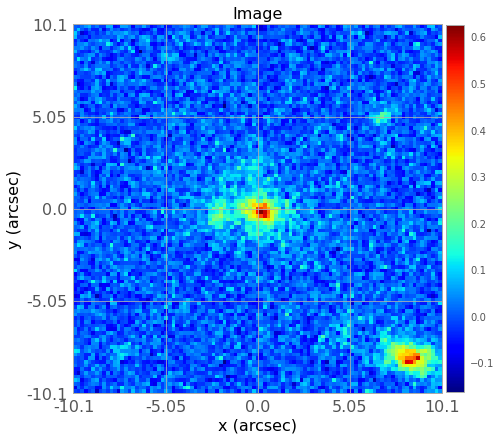

In [35]:
# load r-band imaging
imaging_r = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_r_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_r_noise_map_image.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_r_psf_image.fits'),
                               pixel_scales=0.2)

# load g-band imaging
imaging_g = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_g_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_g_noise_map_image.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_g_psf_image.fits'),
                               pixel_scales=0.2)

# plot images for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r,# visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.figures(image=True)
print('Plotting g-band')
imaging_plotter_g = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_g,# visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_g.figures(image=True)

In [89]:
# set up aggregator to examine the results on Experiment 4

# FOR SOME THE ORDER LISTED IS PHASE 2, 1, 3!
agg = af.Aggregator(directory=f'{output_folder}')
agg = agg.filter(agg.directory.contains("experiment_4"))

samples_gen = agg.values("samples")

"""
When we print this the length of this generator converted to a list of outputs we see 3 different NestSamples 
instances. These correspond to each fit of each phase to each of our 3 images.
"""
print("NestedSampler Samples: \n")
print(samples_gen)
print()
print("Total Samples Objects = ", len(list(samples_gen)), "\n")

# Or do this
samples = list(agg.values("samples"))
model = agg.model_results

print(model)
#print(samples[0].max_log_likelihood_vector)
#print(samples[0].max_log_posterior_vector)

Aggregator loading phases... could take some time.

 A total of 15 phases and results were found.
Filter found a total of 3 results
NestedSampler Samples: 


Total Samples Objects =  3 



Bayesian Evidence                                                                         1232.06293412
Maximum Likelihood                                                                        1253.96618117

Maximum Log Likelihood Model:

galaxies
    lens
        mass
            intensity                                                                     4.298
            effective_radius                                                              0.492
            sersic_index                                                                  0.747
            mass_to_light_ratio                                                           0.877
    source
        bulge
            intensity                                                                     0.045
            centre
                

In [37]:
# take the samples info for the max log likelihood, etc.
results = list(agg.values("samples"))[2]
# max log likelihood instance won't load because it's outside the bounds of my priors... which is stupid af.
print(results.max_log_likelihood_instance)
sample = results.max_log_likelihood_sample
#instance = sample.instance_for_model(results.max_log_likelihood_sample)
#print(instance)

In [38]:
help(results)

Help on NestSamples in module autofit.non_linear.samples object:

class NestSamples(PDFSamples)
 |  NestSamples(model: autofit.mapper.model_mapper.ModelMapper, samples: List[autofit.non_linear.samples.Sample], number_live_points: int, log_evidence: float, total_samples: float, unconverged_sample_size: int = 100, time: float = None)
 |  
 |  Method resolution order:
 |      NestSamples
 |      PDFSamples
 |      OptimizerSamples
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model: autofit.mapper.model_mapper.ModelMapper, samples: List[autofit.non_linear.samples.Sample], number_live_points: int, log_evidence: float, total_samples: float, unconverged_sample_size: int = 100, time: float = None)
 |      The *Output* classes in **PyAutoFit** provide an interface between the results of a `NonLinearSearch` (e.g.
 |      as files on your hard-disk) and Python.
 |      
 |      For example, the output class can be used to load an instance of the best-fit model, g

# Max log likelihood model

### Manually input max log likelihood model because it doesn't want to let me access it.

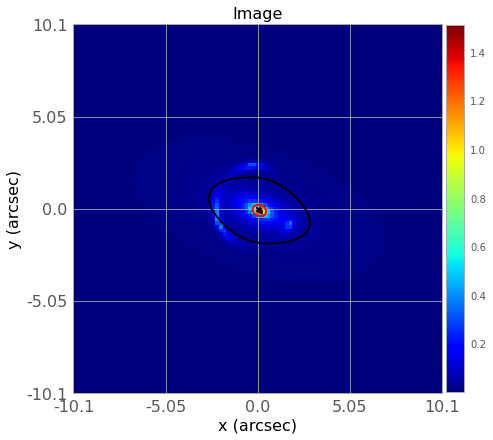

In [42]:
lens = al.Galaxy(
    redshift=instance.galaxies.lens.redshift,
    bulge=al.lmp.EllipticalSersic(elliptical_comps=(-0.214, 0.279),
                                  centre=(-0.09977304157510128, 0.09981813647810622),
                                 intensity=0.034,
                                 sersic_index=3.501,
                                 mass_to_light_ratio=8.550,
                                 effective_radius=2.228),
    dark=al.mp.SphericalNFWMCRLudlow(mass_at_200=130966678743.191)
)

source = al.Galaxy(
    redshift=instance.galaxies.source.redshift,
    bulge=al.lp.SphericalExponential(intensity=0.112,
                                     centre=(0.221, -0.212),
                                     effective_radius=0.232)
)

tracer = al.Tracer.from_galaxies(galaxies=[lens, source])

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures(image=True)

### Try to pull Einstein radius from lens galaxy and grid. These are exactly the same. The Tracer is just where the galaxy is specified.

In [60]:
print(
    "Einstein Radius (arcsec) via Galaxy = ",
    lens.einstein_radius_from_grid(grid=grid),
)
print(
    "Einstein Mass (angular) via Galaxy = ",
    lens.einstein_mass_angular_from_grid(grid=grid),
)

kpc_per_arcsec = al.util.cosmology.kpc_per_arcsec_from(
    redshift=lens.redshift[0], cosmology=cosmo
)

einstein_radius = lens.einstein_radius_from_grid(grid=grid)

einstein_radius_kpc = einstein_radius * kpc_per_arcsec
print("Einstein Radius (kpc) = ", einstein_radius_kpc)

Einstein Radius (arcsec) via Galaxy =  2.186904227338246
Einstein Mass (angular) via Galaxy =  15.024824258171073
Einstein Radius (kpc) =  11.38284900959853


### Einstein mass.

In [58]:
einstein_mass = lens.einstein_mass_angular_from_grid(grid=grid)
print("Einstein Mass (angular) = ", einstein_mass)

critical_surface_density = al.util.cosmology.critical_surface_density_between_redshifts_from(
    redshift_0=lens.redshift[0], redshift_1=source.redshift[0], cosmology=cosmo
)

einstein_mass_solar = einstein_mass * critical_surface_density

print("Einstein Mass (Msol) = ", einstein_mass_solar) # Gives it in solar masses
print("Einstein Mass (Msol) = ", "{:.4e}".format(einstein_mass_solar))
print(f'Log Einstein Mass = {np.log10(einstein_mass_solar)}')

Einstein Mass (angular) =  15.024824258171073
Einstein Mass (Msol) =  1456940820059.0918
Einstein Mass (Msol) =  1.4569e+12
Log Einstein Mass = 12.16344191138306


In [47]:
print(f'Log Mass at 200 (whatever that means): {np.log10(791085293021575.5)}')

Log Mass at 200 (whatever that means): 14.898223310667886


In [48]:
print(f'Log Stellar Mass: {stellar_mass}')

Log Stellar Mass: [11.630485]


### Do the same from the tracer

In [59]:
image_plane_galaxy = tracer.planes[0].galaxies[0]
source_plane_galaxy = tracer.planes[1].galaxies[0]

einstein_radius = image_plane_galaxy.einstein_radius_from_grid(grid=grid)
print("Einstein Radius via Tracer (arcsec) = ", einstein_radius)

kpc_per_arcsec = al.util.cosmology.kpc_per_arcsec_from(
    redshift=image_plane_galaxy.redshift[0], cosmology=cosmo
)
einstein_radius_kpc = einstein_radius * kpc_per_arcsec
print("Einstein Radius via Tracer (kpc) = ", einstein_radius_kpc)

einstein_mass = image_plane_galaxy.einstein_mass_angular_from_grid(grid=grid)
print("Einstein Mass via Tracer (angular) = ", einstein_mass)

critical_surface_density = al.util.cosmology.critical_surface_density_between_redshifts_from(
    redshift_0=image_plane_galaxy.redshift[0],
    redshift_1=source_plane_galaxy.redshift[0],
    cosmology=cosmo,
)
einstein_mass_solar = einstein_mass * critical_surface_density
print("Einstein Mass via Tracer (Msol) = ", einstein_mass_solar)
print("Einstein Mass via Tracer (Msol) = ", "{:.4e}".format(einstein_mass_solar))
print(f'Log Einstein Mass = {np.log10(einstein_mass_solar)}')

Einstein Radius via Tracer (arcsec) =  2.186904227338246
Einstein Radius via Tracer (kpc) =  11.38284900959853
Einstein Mass via Tracer (angular) =  15.024824258171073
Einstein Mass via Tracer (Msol) =  1456940820059.0918
Einstein Mass via Tracer (Msol) =  1.4569e+12
Log Einstein Mass = 12.16344191138306


### Convergence, etc ... Not sure what this means.

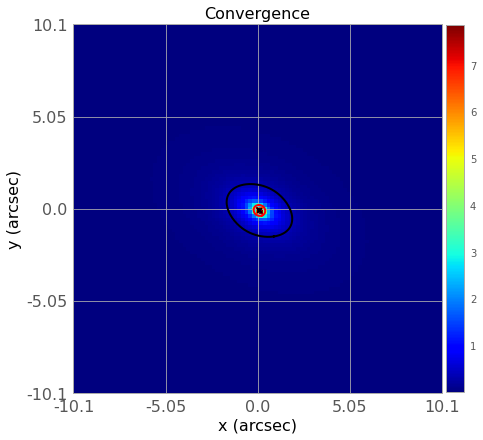

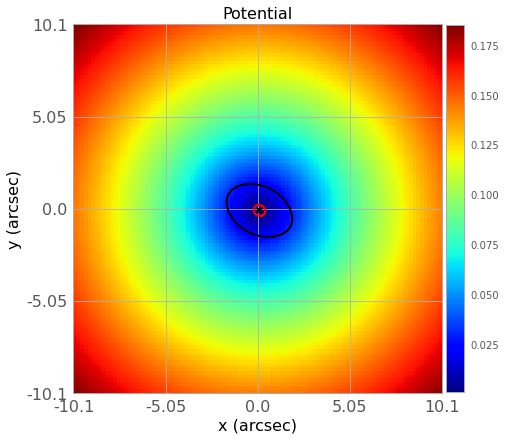

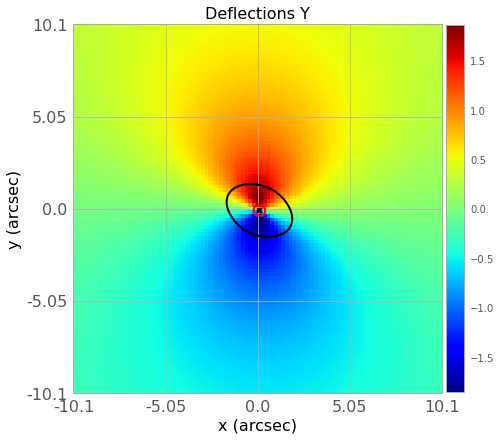

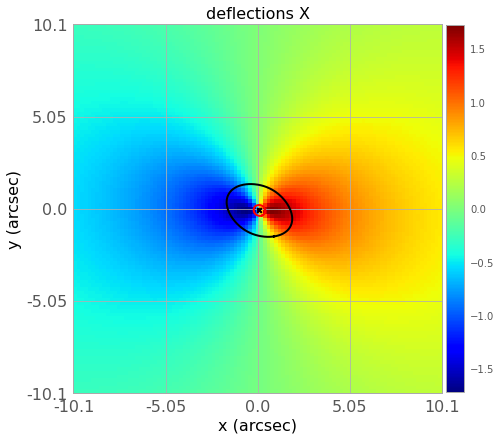

In [84]:
convergence = lens.convergence_from_grid(grid=grid)
potential = lens.potential_from_grid(grid=grid)
deflections = lens.deflections_from_grid(grid=grid)


galaxy_plotter = aplt.GalaxyPlotter(
    galaxy=lens, grid=grid
)
galaxy_plotter.figures(
    convergence=True, potential=True, deflections_y=True, deflections_x=True
)

### Dark matter fraction at radius ()

In [79]:
dm_R_eff = lens.dark_fraction_at_radius(radius=lens.bulge.effective_radius)
print('Dark matter fraction at half-light radius: ', dm_R_eff)
dm_R_huge = lens.dark_fraction_at_radius(radius=1000000*lens.bulge.effective_radius)
print('Dark matter fraction at half-light radius: ', dm_R_huge)

# I'm not sure what this even means.

Dark matter fraction at half-light radius:  0.012530903592302476
Dark matter fraction at half-light radius:  0.999999999999995


## Look at median 

In [61]:
instance = results.median_pdf_instance
print(instance.galaxies.lens)

Redshift: [0.40662315]
Light Profiles:
EllipticalSersic
centre: (-0.09977304157510128, 0.09981813647810622)
elliptical_comps: (-0.18325600373395431, 0.13298506076531313)
axis_ratio: 0.6307575019633196
phi: -27.01619525931616
mass_to_light_ratio: 5.7030699093746
intensity: 0.03885333355525738
effective_radius: 2.037111021516207
sersic_index: 3.16224160368636
id: 92
_assertions: []
cls: <class 'autogalaxy.profiles.light_and_mass_profiles.EllipticalSersic'>
Mass Profiles:
EllipticalSersic
centre: (-0.09977304157510128, 0.09981813647810622)
elliptical_comps: (-0.18325600373395431, 0.13298506076531313)
axis_ratio: 0.6307575019633196
phi: -27.01619525931616
mass_to_light_ratio: 5.7030699093746
intensity: 0.03885333355525738
effective_radius: 2.037111021516207
sersic_index: 3.16224160368636
id: 92
_assertions: []
cls: <class 'autogalaxy.profiles.light_and_mass_profiles.EllipticalSersic'>
SphericalNFWMCRLudlow
mass_at_200: 30713640082.05637
redshift_object: [0.40662315]
redshift_source: [0.787

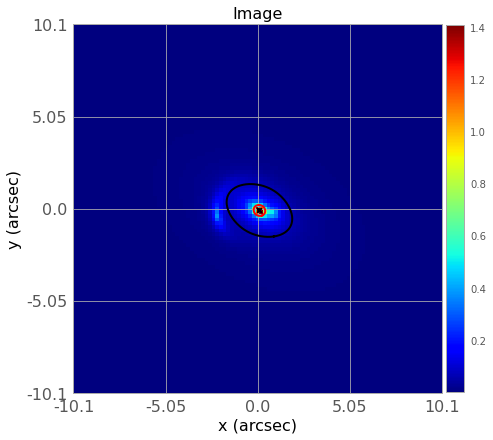

In [62]:
lens = instance.galaxies.lens
source = instance.galaxies.source

grid = al.Grid2DIterate.uniform(
    shape_native=(101, 101), pixel_scales=0.2, fractional_accuracy=0.9999
)

hst_grid = al.Grid2DIterate.uniform(
    shape_native=(404, 404), pixel_scales=0.05, fractional_accuracy=0.9999
)

tracer = al.Tracer.from_galaxies(
    galaxies=[lens, source], cosmology=cosmo
)

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures(image=True)

In [63]:
image_plane_galaxy = tracer.planes[0].galaxies[0]
source_plane_galaxy = tracer.planes[1].galaxies[0]

einstein_radius = image_plane_galaxy.einstein_radius_from_grid(grid=grid)
print("Einstein Radius via Tracer (arcsec) = ", einstein_radius)

kpc_per_arcsec = al.util.cosmology.kpc_per_arcsec_from(
    redshift=image_plane_galaxy.redshift[0], cosmology=cosmo
)
einstein_radius_kpc = einstein_radius * kpc_per_arcsec
print("Einstein Radius via Tracer (kpc) = ", einstein_radius_kpc)

einstein_mass = image_plane_galaxy.einstein_mass_angular_from_grid(grid=grid)
print("Einstein Mass via Tracer (angular) = ", einstein_mass)

critical_surface_density = al.util.cosmology.critical_surface_density_between_redshifts_from(
    redshift_0=image_plane_galaxy.redshift[0],
    redshift_1=source_plane_galaxy.redshift[0],
    cosmology=cosmo,
)
einstein_mass_solar = einstein_mass * critical_surface_density
print("Einstein Mass via Tracer (Msol) = ", einstein_mass_solar)
print("Einstein Mass via Tracer (Msol) = ", "{:.4e}".format(einstein_mass_solar))
print(f'Log Einstein Mass = {np.log10(einstein_mass_solar)}')

Einstein Radius via Tracer (arcsec) =  1.5825519059399076
Einstein Radius via Tracer (kpc) =  8.237191720595703
Einstein Mass via Tracer (angular) =  7.868026233869356
Einstein Mass via Tracer (Msol) =  762953921886.0358
Einstein Mass via Tracer (Msol) =  7.6295e+11
Log Einstein Mass = 11.882498309809522


In [67]:
print(f'Log Stellar Mass: {stellar_mass}')

Log Stellar Mass: [11.668818]


# use corner.py to look at the PDFs

Phase 1
Parameter names: ['intensity', 'effective_radius', 'sersic_index', 'mass_to_light_ratio', 'intensity', 'centre_0', 'centre_1', 'effective_radius']
Parameter labels: ['I', 'R', 'n', 'Psi', 'I', 'y', 'x', 'R']


Phase 2
Parameter names: ['elliptical_comps_0', 'elliptical_comps_1', 'intensity', 'sersic_index', 'effective_radius', 'centre_0', 'centre_1']
Parameter labels: ['\\xi', '\\xi', 'I', 'n', 'R', 'y', 'x']


Phase 3
Parameter names: ['elliptical_comps_0', 'elliptical_comps_1', 'intensity', 'sersic_index', 'intensity', 'centre_0', 'centre_1', 'effective_radius', 'mass_to_light_ratio', 'mass_at_200', 'effective_radius']
Parameter labels: ['\\xi', '\\xi', 'I', 'n', 'I', 'y', 'x', 'R', 'Psi', 'm200', 'R']


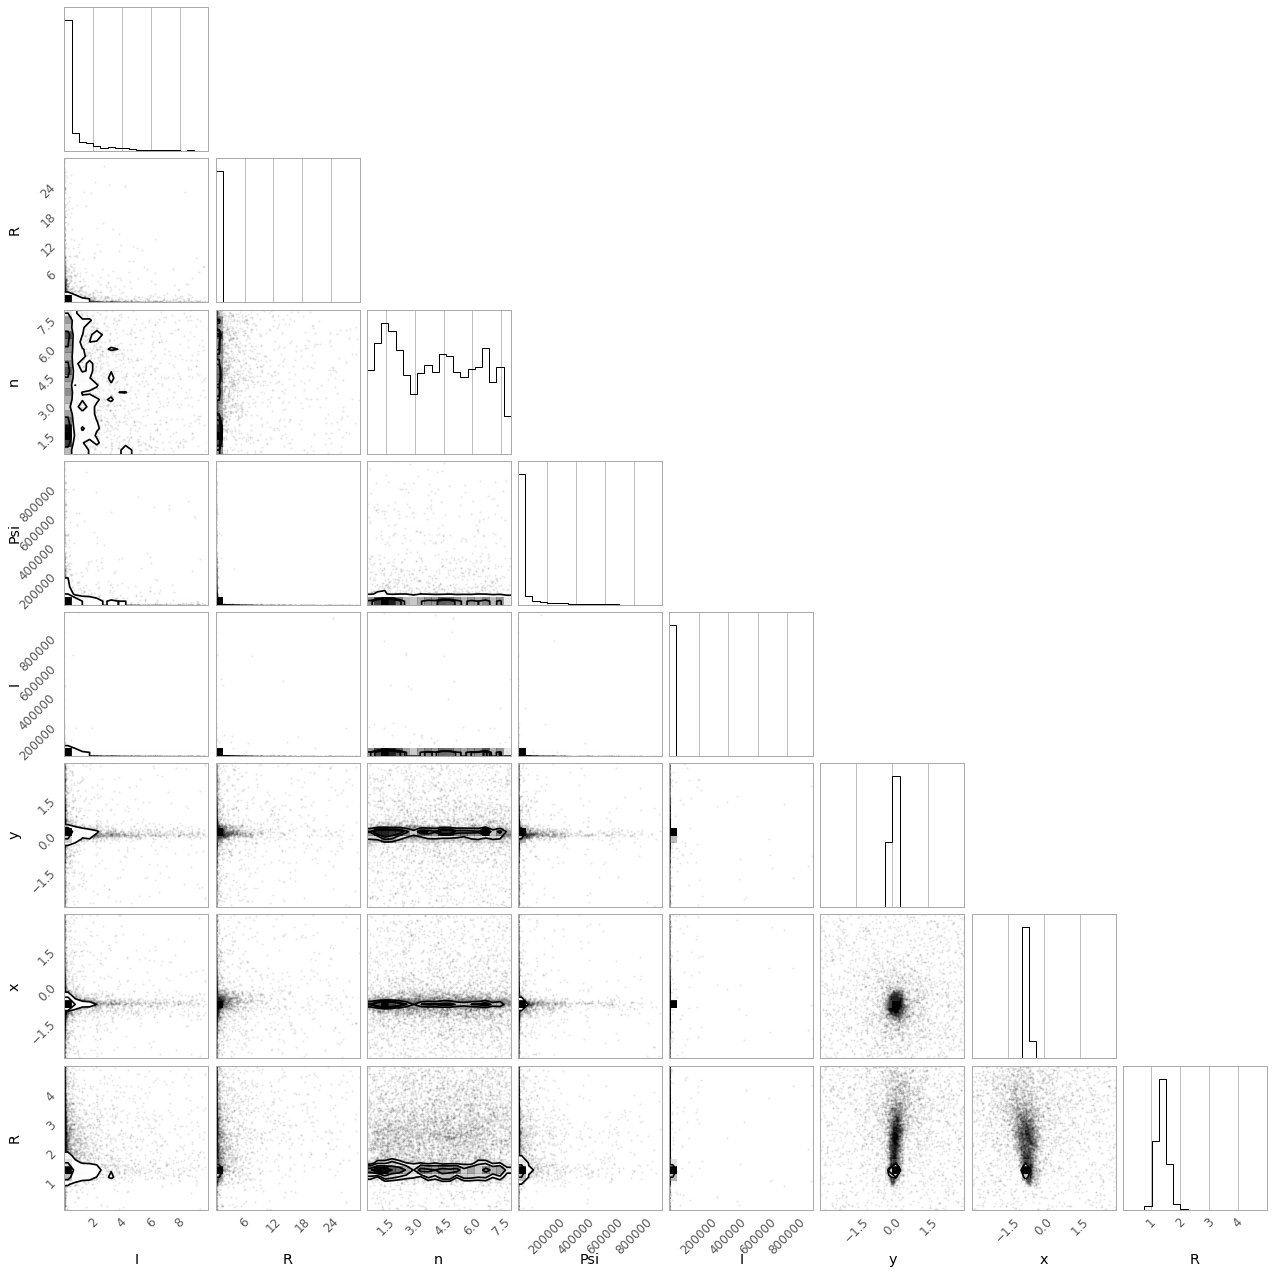

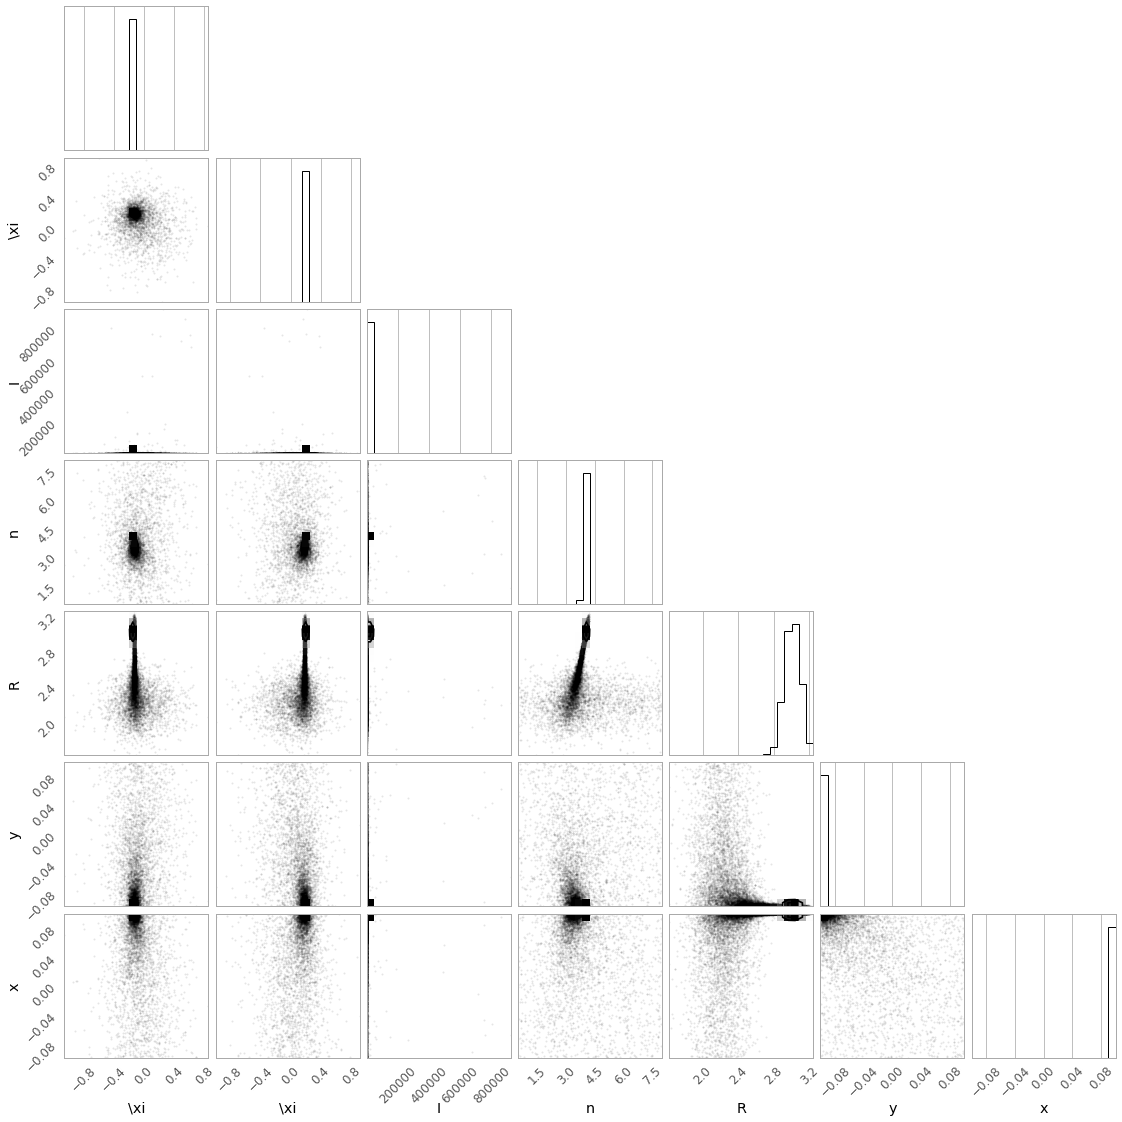

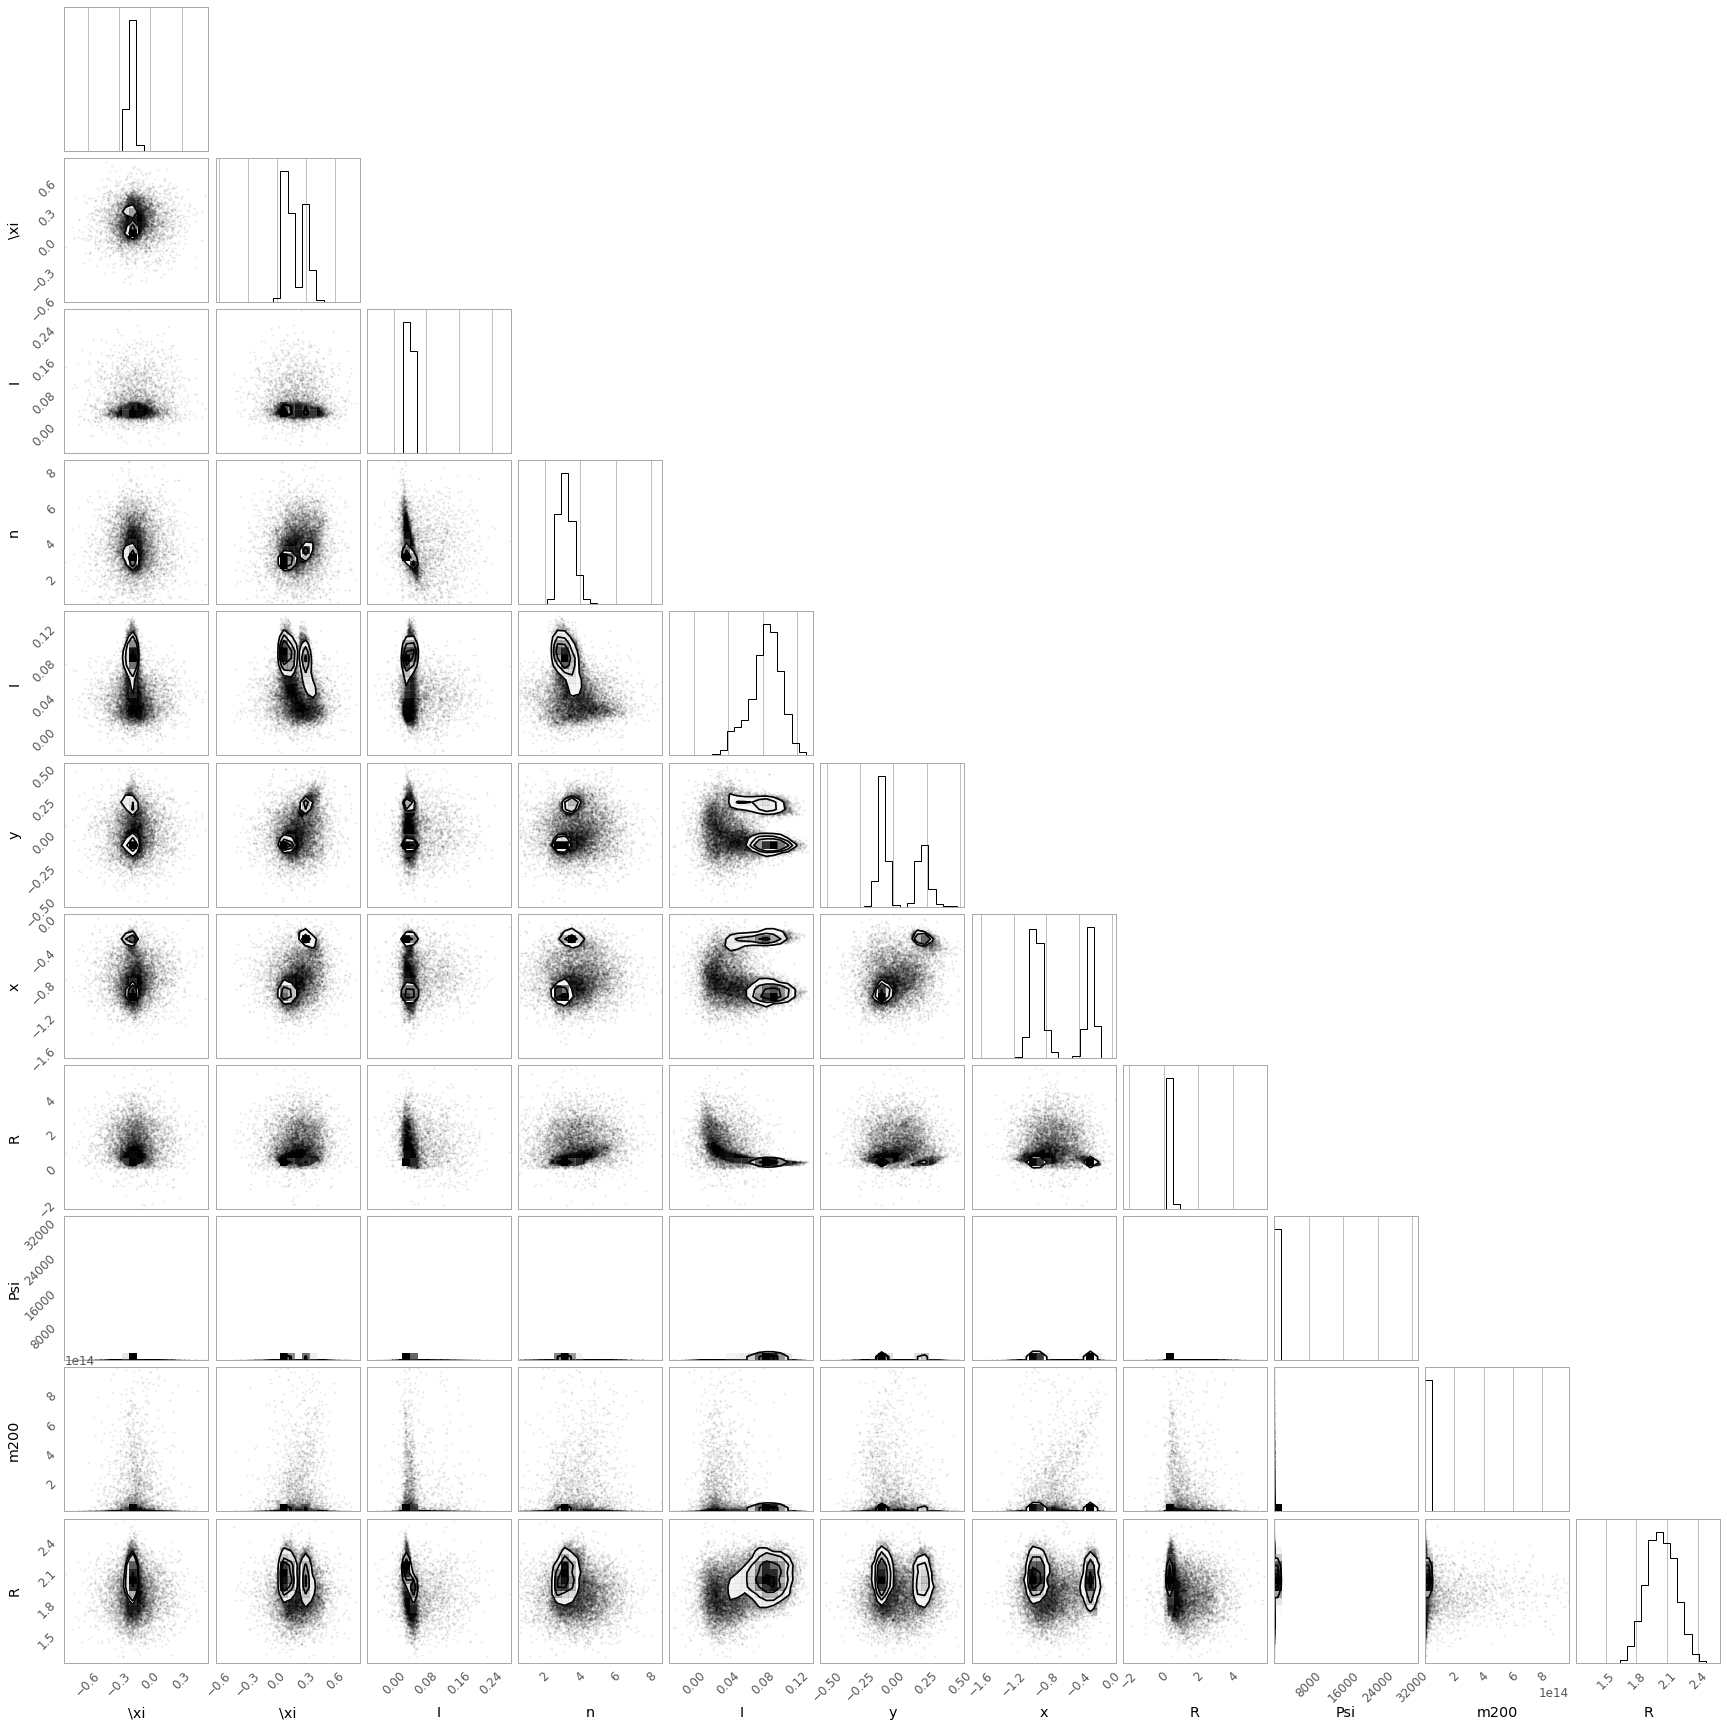

In [95]:
import corner
#

phase = 0
for samples in agg.values("samples"):
    phase = phase+1
    model = samples.model
    print(f'Phase {phase}')
    print(f'Parameter names: {model.parameter_names}')
    print(f'Parameter labels: {model.parameter_labels}')
    corner.corner(
         xs=samples.parameters,
         weights=samples.weights,
         labels=model.parameter_labels,
     )

I don't know what below this is...

In [142]:
from collections import Counter # Counter counts the number of occurrences of each item
from itertools import tee, count
import string

def uniquify(seq, suffs = count(1)):
    """Make all the items unique by adding a suffix (1, 2, etc).

    `seq` is mutable sequence of strings.
    `suffs` is an optional alternative suffix iterable.
    """
    not_unique = [k for k,v in Counter(seq).items() if v>1] # so we have: ['name', 'zip']
    # suffix generator dict - e.g., {'name': <my_gen>, 'zip': <my_gen>}
    suff_gens = dict(zip(not_unique, tee(suffs, len(not_unique))))  
    for idx,s in enumerate(seq):
        try:
            suffix = str(next(suff_gens[s]))
        except KeyError:
            # s was unique
            continue
        else:
            seq[idx] += suffix


# iterate through samples generator to fill list
n = 0
for sample in samples:
    parameters = sample.model.parameter_names
    print(parameters)
    uniquify(parameters, (f'_{x!s}' for x in string.ascii_lowercase))
    vector = sample.max_log_likelihood_vector
    print(parameters)
    print(vector)
    result = pd.DataFrame([vector], columns=parameters, index=[n])
    print(sample)
    print(result)#.columns)
    if n==0:
        max_log_likelihoods = result
    else:
        max_log_likelihoods = pd.concat([max_log_likelihoods, result])
    #print(max_log_likelihoods)
    n=n+1
    
max_log_likelihoods
    

['elliptical_comps_0', 'elliptical_comps_1', 'intensity', 'sersic_index', 'mass_to_light_ratio', 'mass_at_200', 'intensity', 'effective_radius', 'centre_0', 'centre_1', 'effective_radius']
['elliptical_comps_0', 'elliptical_comps_1', 'intensity_a', 'sersic_index', 'mass_to_light_ratio', 'mass_at_200', 'intensity_b', 'effective_radius_a', 'centre_0', 'centre_1', 'effective_radius_b']
[-0.18103363748883755, 0.05487794833439358, 0.03831901356845069, 3.7222800869020216, 0.446909482897077, 3762608466.9900746, 0.03341642059411545, 1.9033877977283176, -0.23952487865191285, -1.8186867595354448, 1.2609450140936616]
   elliptical_comps_0  elliptical_comps_1  intensity_a  sersic_index  \
0           -0.181034            0.054878     0.038319       3.72228   

   mass_to_light_ratio   mass_at_200  intensity_b  effective_radius_a  \
0             0.446909  3.762608e+09     0.033416            1.903388   

   centre_0  centre_1  effective_radius_b  
0 -0.239525 -1.818687            1.260945  
['elli

,elliptical_comps_0,elliptical_comps_1,intensity_a,sersic_index,mass_to_light_ratio,mass_at_200,intensity_b,effective_radius_a,centre_0,centre_1,effective_radius_b
0,-0.181034,0.054878,0.038319,3.722280,0.446909,3.762608e+09,0.033416,1.903388,-0.239525,-1.818687,1.260945
1,-0.179755,0.041359,0.054072,2.939940,0.001203,9.537455e+09,0.047161,0.877885,-0.349244,-1.937543,1.756428
2,-0.142112,0.092537,0.050157,2.414843,0.070413,1.680662e+08,0.097908,1.980444,-0.227487,-1.876202,0.553743
3,-0.225547,0.271619,0.038813,3.544347,0.005260,1.058474e+12,0.019127,1.815676,0.002692,-1.112506,2.451885
4,-0.075013,0.303495,0.043064,3.462219,1.368334,1.942446e+11,0.026541,1.740168,-0.312031,-1.813174,1.864348


## I don't know for sure what order these parameters are in. I assume it's lens and then source.. But why would intensity_b be listed before effective_radius_a?

In [143]:
ue3_vectors = np.array([
    samps.error_vector_at_upper_sigma(sigma=3.0) for samps in samples
])

le3_vectors = np.array([
    samps.error_vector_at_lower_sigma(sigma=3.0) for samps in samples
])
print(ue3_vectors)
print(le3_vectors)

[[3.51010926e-01 3.72959247e-01 5.23419420e-02 3.19366913e+00
  2.74225077e+01 9.04639380e+14 2.33548629e-01 2.35722172e-01
  2.88312057e+00 3.09859312e+00 2.38325667e+00]
 [3.38731619e-01 3.60343402e-01 4.80357855e-02 3.60731862e+00
  1.83182473e-01 7.87035873e+00 1.07732831e+01 8.58647477e+00
  2.69235211e+01 9.30949747e+14 2.56872028e-01]
 [3.22396518e-01 3.72921175e-01 5.29196410e-02 2.65831546e+00
  2.82253820e+01 9.08309239e+14 1.60593530e-01 2.44650349e-01
  2.90293564e+00 3.43404607e+00 2.31743425e+00]
 [3.83449660e-01 3.40019262e-01 5.34570716e-02 3.28807914e+00
  8.76600675e+05 8.55339470e+14 4.97809844e+05 5.35140290e-01
  2.78027592e+00 3.20083830e+00 2.36991665e+00]
 [3.12332411e-01 3.58876906e-01 6.30667542e-02 3.40106775e+00
  1.08683253e-01 7.10842282e+00 1.16384631e+01 8.43504739e+00
  2.48571871e+01 9.66177403e+14 2.54825194e-01]]
[[3.59244835e-01 3.83976422e-01 2.98635184e-02 1.64431101e+00
  7.28899604e-03 1.50646247e+11 4.53264560e-04 5.21366388e-01
  3.03760193e+0